# Zero-Shot Learning Experiments: Topic classification

Using https://huggingface.co/zero-shot/ 

In [5]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

In [7]:
print(os.getcwd())
os.chdir("../../../..")
print(os.getcwd())

C:\Users\allie\Documents\GitHub\policy-data-analyzer\tasks\data_augmentation\notebooks\zero_shot_classification
C:\Users\allie\Documents\GitHub\policy-data-analyzer


In [10]:
from tasks.data_loading.src.utils import *
#from tasks.model_evaluation.src.model_evaluator import *
from tasks.data_augmentation.src.zero_shot_classification.nli_topic_classifier import *

### Load labeled sentences from Excel

In [6]:
all_sents_excel = pd.read_excel("../../input/WRI_Policy_Tags.xlsx", engine="openpyxl")

In [7]:
all_sents_excel.head()

Document  \
0  2019 ACUERDO por el que se emiten los Lineamie...   
1  2019 ACUERDO por el que se emiten los Lineamie...   
2  2019 ACUERDO por el que se emiten los Lineamie...   
3  2019 ACUERDO por el que se emiten los Lineamie...   
4  2019 ACUERDO por el que se emiten los Lineamie...   

                                            Sentence    Primary Instrument  \
0  Generar empleo y garantizara la población camp...  Technical assistance   
1  El Programa incentivará a los sujetos agrarios...     General incentive   
2  Los sujetos agrarios beneficiados por el progr...              Supplies   
3  Adicionalmente, contarán con acompañamiento té...  Technical assistance   
4  El sujeto de derecho, recibirá un apoyo económ...       Direct payment    

                Other Instrument(s)               Land Use Type   Category  \
0  Supplies, Credit, Direct payment  Forest, Agriculture (Crop)  Incentive   
1                               NaN  Forest, Agriculture (Crop)  Incentive   
2                               NaN  Forest, Agriculture (Crop)  Incentive   
3                               NaN  Forest, Agriculture (Crop)  Incentive   
4                               NaN  Forest, Agriculture (Crop)  Incentive   

      Unique Policy #                                          Key words  \
0  1 (Sembrando Vida)  insumo, crédito, capacitación, asistencia técnica   
1  1 (Sembrando Vida)                                         incentivar   
2  1 (Sembrando Vida)  apoyo económico, apoyos en especie, insumos, h...   
3  1 (Sembrando Vida)                                               None   
4  1 (Sembrando Vida)                                              pesos   

   Unnamed: 8  Unnamed: 9  ...  Unnamed: 17  Unnamed: 18  Unnamed: 19  \
0         NaN         NaN  ...          NaN          NaN          NaN   
1         NaN         NaN  ...          NaN          NaN          NaN   
2         NaN         NaN  ...          NaN          NaN          NaN   
3         NaN         NaN  ...          NaN          NaN          NaN   
4         NaN         NaN  ...          NaN          NaN          NaN   

   Unnamed: 20  Unnamed: 21  Unnamed: 22  Unnamed: 23  Unnamed: 24  \
0          NaN          NaN          NaN          NaN          NaN   
1          NaN          NaN          NaN          NaN          NaN   
2          NaN          NaN          NaN          NaN          NaN   
3          NaN          NaN          NaN          NaN          NaN   
4          NaN          NaN          NaN          NaN          NaN   

   Unnamed: 25  Unnamed: 26  
0          NaN          NaN  
1          NaN          NaN  
2          NaN          NaN  
3          NaN          NaN  
4          NaN          NaN  

[5 rows x 27 columns]

### Try out which hypothesis template gives the "best" results

In [10]:
test_sent = 'Generar empleo y garantizara la población campesina el bienestar y su participación e incorporación en el desarrollo nacional, y fomentará la actividad agropecuaria y forestal para el óptimo uso de la tierra, con obras de infraestructura, insumos, créditos, servicios de capacitación y asistencia técnica'
test_labels = ['direct payment', 'technical assistance', 'credit']
all_labels = ["direct payment", "tax deduction", "credit", "guarantee", "technical assistance", "supplies", "fine"]
hyp_template_list = ['This text is about {}.', 'This text contains incentives about {}s', 
                     "This text contains information about {}s", "This text contains {}"]

results = []
classifier = pipeline('zero-shot-classification',
                      model='facebook/bart-large-mnli')

for hyp in hyp_template_list:
    result = classify_sentence(test_sent, all_labels,
                        hyp, classifier, allow_multi_class=False, all_probs=True)
    
    print(f"Hypothesis: {hyp}")
    print(f"Labels and scores:")
    for pretty in result:
        print(pretty)
    print("-----------------------------------------------------------\n")
    results.append(result)
    

Some weights of the model checkpoint at facebook/bart-large-mnli were not used when initializing BartForSequenceClassification: ['model.encoder.version', 'model.decoder.version']
- This IS expected if you are initializing BartForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BartForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Hypothesis: This text is about {}.
Labels and scores:
('technical assistance', 0.6607312560081482)
('guarantee', 0.2117200344800949)
('credit', 0.05324256792664528)
('supplies', 0.031038496643304825)
('fine', 0.019294213503599167)
('direct payment', 0.01415798719972372)
('tax deduction', 0.009815499186515808)
-----------------------------------------------------------

Hypothesis: This text contains incentives about {}s
Labels and scores:
('technical assistance', 0.43722790479660034)
('supplies', 0.185050368309021)
('guarantee', 0.12045128643512726)
('credit', 0.10245632380247116)
('direct payment', 0.0627651959657669)
('tax deduction', 0.05834724009037018)
('fine', 0.033701688051223755)
-----------------------------------------------------------

Hypothesis: This text contains information about {}s
Labels and scores:
('technical assistance', 0.7476929426193237)
('guarantee', 0.0772569328546524)
('supplies', 0.07667051255702972)
('credit', 0.03330483287572861)
('fine', 0.02758225612342

In [11]:
# Load data
data_excel = pd.read_excel("../../input/WRI_Policy_Tags.xlsx", engine="openpyxl", sheet_name=None)
labeled_sents = labeled_sentences_from_excel(data_excel)
all_sents = sentences_from_model_output(labeled_sents)
all_labels = labels_from_model_output(labeled_sents)
label_names = unique_labels(all_labels)

### 3. Binary classification

In [13]:
label_names = ["not incentives", "incentives"]
binary_labels = list(map(lambda x: "incentives" if x != "Unknown" else "not incentives", all_labels))

In [15]:
bin_numeric_labels = labels2numeric(binary_labels, label_names)
plo

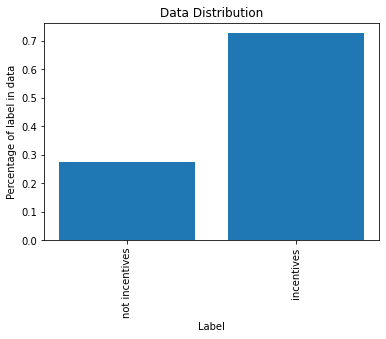

Label counts:
{'not incentives': 0.273972602739726, 'incentives': 0.726027397260274}


In [16]:
plot_data_distribution(bin_numeric_labels, label_names)

In [19]:
bin_model_preds, bin_scores = classify_sentences_topic(labeled_sents, label_names, "This text contains information about {}s", classifier)

100%|██████████| 657/657 [20:32<00:00,  1.88s/it]


In [22]:
bin_numeric_preds = labels2numeric(bin_model_preds, label_names)

In [23]:
evaluator = ModelEvaluator(label_names, y_true=bin_numeric_labels, y_pred=bin_numeric_preds)

In [24]:
print("Average weighted f1:", evaluator.avg_f1[1])

Average weighted f1: 0.6045778252063505


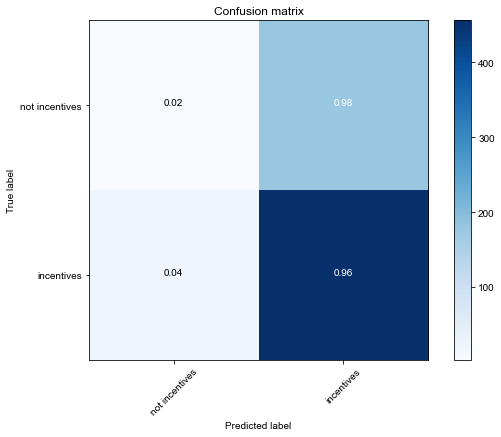

In [25]:
evaluator.plot_confusion_matrix(color_map='Blues')

### 4. Multi-class classification

In [28]:
label_names = ["Direct payment", "Tax deduction", "Credit", "Guarantee", "Technical assistance", "Supplies", "Fine", "Unknown"]

In [ ]:
multi_model_preds, multi_scores = classify_sentences_topic(labeled_sents, label_names, "This text contains information about {}s", classifier)

In [ ]:
multi_numeric_labels = labels2numeric(all_labels, label_names)
multi_numeric_preds = labels2numeric(multi_model_preds, label_names)

In [ ]:
evaluator = ModelEvaluator(label_names, y_true=multi_numeric_labels, y_pred=multi_numeric_preds)

In [ ]:
print("Average weighted f1:", evaluator.avg_f1[1])

In [ ]:
evaluator.plot_confusion_matrix(color_map='Blues')

### Tangent: Separate mutliple labels into a list from JSON file

In [ ]:
import json

In [ ]:
with open("../input/tagged_sentences_all.json", "r") as fjson: 
    jsents = json.load(fjson)

In [ ]:
len(jsents), jsents.keys()

In [ ]:
sentence_tags_dict = {}
new_json = {}

for keydoc, document in jsents.items():
    new_json[keydoc] = {}
    for keysec, section in document.items():
        new_json[keydoc][keysec] = {}
        new_json[keydoc][keysec]['tags'] = section['tags']
        new_json[keydoc][keysec]['sentences'] = {}
        for sentid, sentence in section['sentences'].items():
            new_labels = [label.strip() for label in sentence['labels'].split(", ")]

            updated_labels = []
            for label in new_labels:
                if "(" in label:
                    updated_labels.append("Direct payment")
                else:
                    updated_labels.append(label)
            new_json[keydoc][keysec]['sentences'][sentid] = {'text': sentence['text'], 'labels': updated_labels}

In [ ]:
len(new_json), new_json.keys()

In [ ]:
with open("allcountries_tagged_sents.json", "w") as wjson:
    json.dump(new_json, wjson)

In [ ]:
data = load_file("allcountries_tagged_sents.json")

In [ ]:
dataset_map = labeled_sentences_from_dataset(data)

In [ ]:
dataset_map['1']

In [ ]:
dataset_labels = labels_from_dataset(data)
dataset_labels[:10], set(dataset_labels)

In [ ]:
numeric_labels = numeric_labels_from_dataset(data)
numeric_labels[:10]